In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import yfinance as yf

In [11]:
import math
def sigmoid(x):
    try:
        sig = 1 / (1 + math.exp(-x))
    except:
        sig = 0
    return sig

def relu(x, bound = 100):
    return min(max(0,x),bound)

[*********************100%***********************]  1 of 1 completed


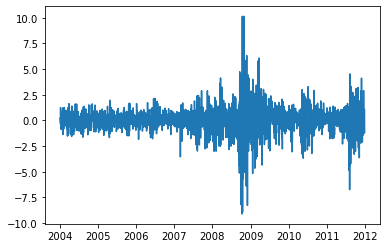

In [12]:
data = yf.download("^GSPC", start="2004-01-01", end="2012-01-01")

data['pct_change'] = data.Open.pct_change()

data['log_ret'] = np.log(data.Open) - np.log(data.Open.shift(1))


data['log_ret * 100'] = data['log_ret'] * 100

returns = data['log_ret * 100'].values[1:]

plt.plot(data['log_ret * 100'])

# 1. LSTM

\begin{align}
y_t &= \sigma_t \epsilon_t \\
\sigma_t^2 &= w_t + \alpha y_{t-1}^2 + \beta \sigma_{t-1}^2 \\
w_t &= f(\gamma_0 + \gamma_1 h_t) \qquad \text{authors always used f(x) = x for this function} \\ 
h_t &= o_t \phi_h (c_t) \\
c_t &= f_t c_{t-1}+ i_t \tilde{c}_t \\
\tilde{c}_t &= \phi_\tilde{c} (v_1 x_t + \mu_1 h_{t-1} + b_{\tilde c}) \\
o_t &= \phi_o (v_2 x_t + \mu_2 h_{t-1} + b_o) \\
i_t &= \phi_i (v_3 x_t + \mu_3 h_{t-1} + b_i) \\
f_t &= \phi_f (v_4 x_t + \mu_4 h_{t-1} + b_f) \\
\end{align}
Literature says: $\phi_j = $ sigmoid, for $j \in (o,i,f)$, $\phi_c$ and $\phi_h$ = tanh. I would at least choose $\phi_h$ = relu or sigmoid

In [23]:
def LSTM_garch(pars, nun_lin_func, returns):
    (alpha, beta, gamma_0, gamma_1, v_11, v_12, v_21, v_22, v_31, v_32, v_41, v_42, mu_1, mu_2, mu_3, mu_4, b_f, b_i, b_o, b_c) = pars
    iT = len(returns)
    sigma_2 = np.zeros(iT)
    w = np.zeros(iT)
    h = np.zeros(iT)
    f = np.zeros(iT)
    ij = np.zeros(iT)
    o = np.zeros(iT)
    c = np.zeros(iT)
    c_tilde = np.zeros(iT)
    for i in range(iT):
        if i == 0:
            sigma_2[i] = 0.1/(1- alpha - beta)
        else:
            f[i] = sigmoid(v_41 * np.sign(returns[i-1]) *  returns[i-1]**2 + v_42 * sigma_2[i-1] + mu_4 * h[i-1] + b_f) # here sigmoid instead of ReLU
            ij[i] = sigmoid(v_31 * np.sign(returns[i-1]) *  returns[i-1]**2 + v_32 * sigma_2[i-1] + mu_3 * h[i-1] + b_i)
            o[i] = sigmoid(v_21 * np.sign(returns[i-1]) *  returns[i-1]**2 + v_22 * sigma_2[i-1] + mu_2 * h[i-1] + b_o)
            c_tilde[i] = sigmoid(v_21 * np.sign(returns[i-1]) *  returns[i-1]**2 + v_22 * sigma_2[i-1] + mu_2 * h[i-1] + b_o)
            c[i] = f[i] * c[i-1] + ij[i] * c_tilde[i]
            h[i] = o[i] * sigmoid(c[i])
            w[i] = gamma_0 + gamma_1 * h[i] 
            sigma_2[i] = w[i] + alpha * returns[i-1]**2 + beta * sigma_2[i-1]
    return sigma_2, w, h

def LSTM_garch_loglike(start_v, nun_lin_func, returns):
    sigma_2 = LSTM_garch(start_v, nun_lin_func, returns)[0]
    LogL = - np.sum(-np.log(sigma_2) -  returns**2/sigma_2)
    return LogL

In [24]:
#cons = ({"type": "ineq", "func" : lambda x: np.array(x)})
vP0 = np.array((0.1, 0.25, 0.52, 0.1 , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
my_bounds = ((0.0001,1), (0.0001,1), (0.0001, 3),  (0.0001, 3) , (-10, 10), (-10, 10), (-10,10)  ,(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ))

print(len(vP0))
print(len(my_bounds))
res = opt.minimize(LSTM_garch_loglike, vP0, args = (relu, returns),
                  bounds = my_bounds,
                    method = "Nelder-Mead",
                  options = {"disp": True, "maxiter": 500000})

#par_names = ["alpha", "beta", "gamma0", "gamma1",  "v11",  "v2",  "v3",  "v4"]
"""
plt.bar(par_names, res.x)
plt.show()

plt.bar(par_names[4:], res.x[4:])
plt.show()"""

20
20


C:\Users\mobem\AppData\Local\Temp\ipykernel_14564\1778717333.py:28: RuntimeWarning: invalid value encountered in log
  LogL = - np.sum(-np.log(sigma_2) -  returns**2/sigma_2)


Optimization terminated successfully.
         Current function value: 1949.664240
         Iterations: 1527
         Function evaluations: 2021


'\nplt.bar(par_names, res.x)\nplt.show()\n\nplt.bar(par_names[4:], res.x[4:])\nplt.show()'